In [1]:
#Libraries
import pandas as pd
import numpy as np


In [2]:
#Dataset
movies=pd.read_csv(r'C:\Users\sarim\OneDrive\Desktop\Project\Machine Learning\Datasets\smaller\movies.csv', usecols=['movieId','title','genres'], dtype={'movieId':'int32','title':'str','genre':'str'})
ratings=pd.read_csv(r'C:\Users\sarim\OneDrive\Desktop\Project\Machine Learning\Datasets\smaller\ratings.csv',usecols=['userId', 'movieId', 'rating'],dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [3]:
print(movies.shape)
print(ratings.shape)
print('\n',movies.isnull().sum())
print('\n',ratings.isnull().sum())
#movies.info()
#ratings.info()

(9742, 3)
(100836, 3)

 movieId    0
title      0
genres     0
dtype: int64

 userId     0
movieId    0
rating     0
dtype: int64


In [4]:
#Cleaning


#Shrinking dataset for our system

smallmovie = movies[0:1000]
movieid = list(smallmovie["movieId"])

smallrating=ratings[(ratings["movieId"].isin(movieid))]


movies = smallmovie
ratings = smallrating

In [5]:
print(movies.shape)
print(ratings.shape)
print('\n',movies.isnull().sum())
print('\n',ratings.isnull().sum())
#movies.info()
#ratings.info()

(1000, 3)
(29633, 3)

 movieId    0
title      0
genres     0
dtype: int64

 userId     0
movieId    0
rating     0
dtype: int64


In [6]:
#to insert url of movies to the database

import os, requests, lxml, re, json, urllib.request
from bs4 import BeautifulSoup
from serpapi import GoogleSearch

def get_image_url(name):
    global headers,params,html,soup
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.114 Safari/537.36"
    }

    params = {
        "q": name, # search query
        "tbm": "isch",                # image results
        "hl": "en",                   # language of the search
        "gl": "us",                   # country where search comes from
        "ijn": "0"                    # page number
    }

    html = requests.get("https://www.google.com/search", params=params, headers=headers, timeout=30)
    soup = BeautifulSoup(html.text, "lxml")
    return get_original_images()[1]
    

def get_images_with_request_headers():
    del params["ijn"]
    params["content-type"] = "image/png" # parameter that indicate the original media type

    return [img["src"] for img in soup.select("img")]

def get_suggested_search_data():
    suggested_searches = []

    all_script_tags = soup.select("script")
    matched_images = "".join(re.findall(r"AF_initDataCallback\(({key: 'ds:1'.*?)\);</script>", str(all_script_tags)))
    matched_images_data_fix = json.dumps(matched_images)
    matched_images_data_json = json.loads(matched_images_data_fix)
    suggested_search_thumbnails = ",".join(re.findall(r'{key(.*?)\[null,\"Size\"', matched_images_data_json))
    suggested_search_thumbnail_encoded = re.findall(r'\"(https:\/\/encrypted.*?)\"', suggested_search_thumbnails)

    for suggested_search, suggested_search_fixed_thumbnail in zip(soup.select(".PKhmud.sc-it.tzVsfd"), suggested_search_thumbnail_encoded):
        suggested_searches.append({
            "name": suggested_search.select_one(".VlHyHc").text,
            "link": f"https://www.google.com{suggested_search.a['href']}",
            "chips": "".join(re.findall(r"&chips=(.*?)&", suggested_search.a["href"])),
            "thumbnail": bytes(suggested_search_fixed_thumbnail, "ascii").decode("unicode-escape")
        })

    return suggested_searches

def get_original_images():

    """
    https://kodlogs.com/34776/json-decoder-jsondecodeerror-expecting-property-name-enclosed-in-double-quotes
    if you try to json.loads() without json.dumps() it will throw an error:
    "Expecting property name enclosed in double quotes"
    """

    google_images = []

    all_script_tags = soup.select("script")

    # # https://regex101.com/r/48UZhY/4
    matched_images_data = "".join(re.findall(r"AF_initDataCallback\(([^<]+)\);", str(all_script_tags)))
    
    matched_images_data_fix = json.dumps(matched_images_data)
    matched_images_data_json = json.loads(matched_images_data_fix)

    # https://regex101.com/r/VPz7f2/1
    matched_google_image_data = re.findall(r'\"b-GRID_STATE0\"(.*)sideChannel:\s?{}}', matched_images_data_json)

    # https://regex101.com/r/NnRg27/1
    matched_google_images_thumbnails = ", ".join(
        re.findall(r'\[\"(https\:\/\/encrypted-tbn0\.gstatic\.com\/images\?.*?)\",\d+,\d+\]',
                   str(matched_google_image_data))).split(", ")

    thumbnails = [
        bytes(bytes(thumbnail, "ascii").decode("unicode-escape"), "ascii").decode("unicode-escape") for thumbnail in matched_google_images_thumbnails
    ]

    # removing previously matched thumbnails for easier full resolution image matches.
    removed_matched_google_images_thumbnails = re.sub(
        r'\[\"(https\:\/\/encrypted-tbn0\.gstatic\.com\/images\?.*?)\",\d+,\d+\]', "", str(matched_google_image_data))

    # https://regex101.com/r/fXjfb1/4
    # https://stackoverflow.com/a/19821774/15164646
    matched_google_full_resolution_images = re.findall(r"(?:'|,),\[\"(https:|http.*?)\",\d+,\d+\]", removed_matched_google_images_thumbnails)

    full_res_images = [
        bytes(bytes(img, "ascii").decode("unicode-escape"), "ascii").decode("unicode-escape") for img in matched_google_full_resolution_images
    ]
    
    for index, (metadata, thumbnail, original) in enumerate(zip(soup.select('.isv-r.PNCib.MSM1fd.BUooTd'), thumbnails, full_res_images), start=1):
        google_images.append({
            "title": metadata.select_one(".VFACy.kGQAp.sMi44c.lNHeqe.WGvvNb")["title"],
            "link": metadata.select_one(".VFACy.kGQAp.sMi44c.lNHeqe.WGvvNb")["href"],
            "source": metadata.select_one(".fxgdke").text,
            "thumbnail": thumbnail,
            "original": original
        })

        #print(original, f'Bs4_Images/original_size_img_{index}.jpg')

    return google_images


In [8]:
movies["url"] = "movieurl"
movies

,movieId,title,genres,url
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,movieurl
1,2,Jumanji (1995),Adventure|Children|Fantasy,movieurl
2,3,Grumpier Old Men (1995),Comedy|Romance,movieurl
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,movieurl
4,5,Father of the Bride Part II (1995),Comedy,movieurl
...,...,...,...,...
995,1297,Real Genius (1985),Comedy,movieurl
996,1298,Pink Floyd: The Wall (1982),Drama|Musical,movieurl
997,1299,"Killing Fields, The (1984)",Drama|War,movieurl
998,1300,My Life as a Dog (Mitt liv som hund) (1985),Comedy|Drama,movieurl


In [9]:
for index in range(0,len(movies["title"])):
    try:
        movies["url"][index]=get_image_url(movies["title"][index])["original"]
    except:
        print(movies["title"][index])

C:\Users\sarim\AppData\Local\Temp\ipykernel_15488\3570067281.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies["url"][index]=get_image_url(movies["title"][index])["original"]


Lamerica (1994)
Down Periscope (1996)
Congo (1995)
Before the Rain (Pred dozhdot) (1994)
Castle Freak (1995)
Goofy Movie, A (1995)
Thirty-Two Short Films About Glenn Gould (1993)
Time to Kill, A (1996)


In [14]:
#excluding bugged movies
nourlmovie = ["Lamerica (1994)",
"Down Periscope (1996)",
"Congo (1995)",
"Before the Rain (Pred dozhdot) (1994)",
"Castle Freak (1995)",
"Goofy Movie, A (1995)",
"Thirty-Two Short Films About Glenn Gould (1993)",
"Time to Kill, A (1996)"]

movies = movies[(~movies["title"].isin(nourlmovie))]

movieid = list(smallmovie["movieId"])

ratings=ratings[(ratings["movieId"].isin(movieid))]


In [15]:
finaldata = movies.merge(ratings, on='movieId')
finaldata.head()

,movieId,title,genres,url,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://i.ytimg.com/vi/tN1A2mVnrOM/maxresdefau...,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://i.ytimg.com/vi/tN1A2mVnrOM/maxresdefau...,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://i.ytimg.com/vi/tN1A2mVnrOM/maxresdefau...,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://i.ytimg.com/vi/tN1A2mVnrOM/maxresdefau...,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://i.ytimg.com/vi/tN1A2mVnrOM/maxresdefau...,17,4.5


In [16]:
movies_average_rating=finaldata.groupby('title')['rating'].mean().sort_values(ascending=False).reset_index().rename(columns={'rating':'Average Rating'})
movies_average_rating.head()

,title,Average Rating
0,"Awfully Big Adventure, An (1995)",5.0
1,Lesson Faust (1994),5.0
2,Heidi Fleiss: Hollywood Madam (1995),5.0
3,Supercop 2 (Project S) (Chao ji ji hua) (1993),5.0
4,In the Realm of the Senses (Ai no corrida) (1976),5.0


In [18]:
movies_rating_count=finaldata.groupby('title')['rating'].count().sort_values(ascending=True).reset_index().rename(columns={'rating':'Rating Count'}) #ascending=False
movies_rating_count_avg=movies_rating_count.merge(movies_average_rating, on='title')
movies_rating_count_avg.head()

,title,Rating Count,Average Rating
0,"Young Poisoner's Handbook, The (1995)",1,3.0
1,In the Realm of the Senses (Ai no corrida) (1976),1,5.0
2,Infinity (1996),1,3.0
3,Bliss (1997),1,3.0
4,"Inkwell, The (1994)",1,1.0


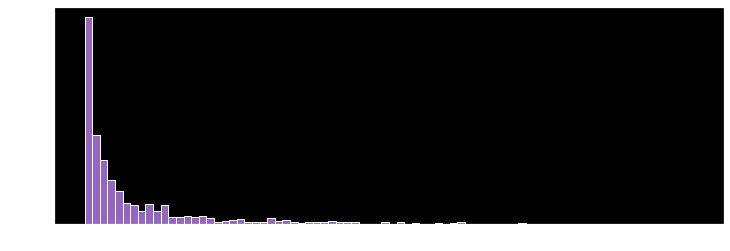

In [19]:
#DataVisualization

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 1)
plt.rcParams["axes.grid"] = False
plt.style.use('dark_background')
%matplotlib inline

plt.figure(figsize=(12,4))
plt.hist(movies_rating_count_avg['Rating Count'],bins=80,color='tab:purple')
plt.ylabel('Ratings Count(Scaled)', fontsize=16)
plt.show()

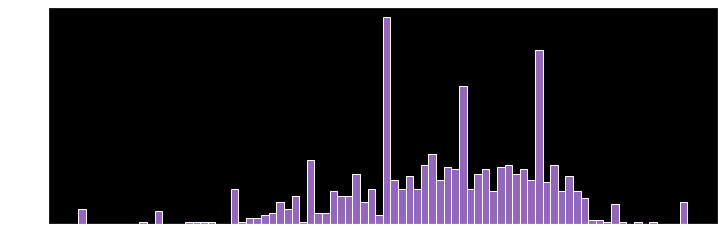

In [20]:
plt.figure(figsize=(12,4))
plt.hist(movies_rating_count_avg['Average Rating'],bins=80,color='tab:purple')
plt.ylabel('Average Rating',fontsize=16)
plt.show()

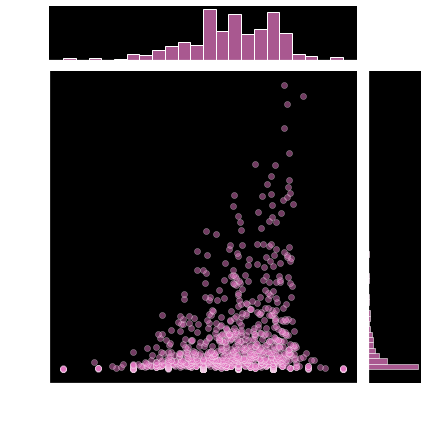

In [22]:
plot=sns.jointplot(x='Average Rating',y='Rating Count',data=movies_rating_count_avg,alpha=0.5, color='tab:pink')
plot

In [24]:
#Cleaning

rating_with_RatingCount = finaldata.merge(movies_rating_count, left_on = 'title', right_on = 'title', how = 'left')
rating_with_RatingCount.head()

,movieId,title,genres,url,userId,rating,Rating Count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://i.ytimg.com/vi/tN1A2mVnrOM/maxresdefau...,1,4.0,215
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://i.ytimg.com/vi/tN1A2mVnrOM/maxresdefau...,5,4.0,215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://i.ytimg.com/vi/tN1A2mVnrOM/maxresdefau...,7,4.5,215
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://i.ytimg.com/vi/tN1A2mVnrOM/maxresdefau...,15,2.5,215
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,https://i.ytimg.com/vi/tN1A2mVnrOM/maxresdefau...,17,4.5,215


In [33]:
popularity_threshold = 5
popular_movies= rating_with_RatingCount[rating_with_RatingCount['Rating Count']>=popularity_threshold]
popular_movies.head()
popular_movies.shape

(28945, 7)

In [89]:
#KNN implementation
from scipy.sparse import csr_matrix
movie_features_df=popular_movies.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movie_features_df_matrix = csr_matrix(movie_features_df.values)

from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine')
model_knn.fit(movie_features_df_matrix)

query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 4)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}'.format(i, movie_features_df.index[indices.flatten()[i]]))

440
Recommendations for Mr. Holland's Opus (1995):

1: Dave (1993)
2: American President, The (1995)
3: Twister (1996)


In [55]:
popular_movies.to_csv(r"C:\Users\sarim\OneDrive\Desktop\Project\Trial\Cinema\static\pmove.csv")